In [5]:
pip install lmdb facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.6/299.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 103.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 1.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Assignment 1: Information Security

### Privacy Risks from Uploading Images To AI Apps 

### Members:
Umema Ashar 22I-2036 

Emad Iqbal 22I-2072 

Hamza Asad 22I-1908 

DSC

In [7]:
print("hi")

hi


In [ ]:
import os
from typing import Optional, List, Tuple
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.io import read_image
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from collections import OrderedDict
import lmdb
import io
from PIL import Image
import numpy as np
from tqdm import tqdm
from pathlib import Path
import cv2
from skimage.util.shape import view_as_windows
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from facenet_pytorch import MTCNN
from skimage import transform as sktf
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from pathlib import Path
import random
import matplotlib.pyplot as plt

In [7]:
split_csv = "/kaggle/input/celeba-dataset/list_eval_partition.csv"

# Properly parse comma-separated
df = pd.read_csv(split_csv, sep=",", header=0, names=["image_id", "partition"])

print(df.head())
print(df["partition"].unique())
print("Train rows:", (df["partition"]==0).sum())
print("Val rows:", (df["partition"]==1).sum())
print("Test rows:", (df["partition"]==2).sum())


     image_id  partition
0  000001.jpg          0
1  000002.jpg          0
2  000003.jpg          0
3  000004.jpg          0
4  000005.jpg          0
[0 1 2]
Train rows: 162770
Val rows: 19867
Test rows: 19962


In [ ]:
class LRUImageCache:
    def __init__(self, max_items: int= 512):
        self.max_items= max_items
        self.cache= OrderedDict()

    def get(self, key):
            if key in self.cache:
                val = self.cache.pop(key)
                self.cache[key] = val  # move to end (most recent)
                return val
            return None

    def put(self, key, val):
        if self.max_items <= 0:
            return
        if key in self.cache:
            self.cache.pop(key)
        elif len(self.cache) >= self.max_items:
            self.cache.popitem(last=False)  # pop oldest
        self.cache[key] = val

class CelebAttributesDataset(Dataset):
    def __init__(
        self,
        img_dir: str,
        split_csv: str,
        split: str = "train",
        target_size: int = 128,
        cache_size: int = 256,
        use_lmdb: bool = False,
        lmdb_path: Optional[str] = None
    ):
        super().__init__()
        self.img_dir = img_dir
        self.target_size = target_size
        self.cache = LRUImageCache(max_items=cache_size)
        self.use_lmdb = use_lmdb
        self.lmdb_path = lmdb_path

        # Read CSV robustly
        try:
            df = pd.read_csv(split_csv, sep=r"\s+", header=None, names=["image_id", "partition"])
            if "partition" not in df.columns or df["partition"].isna().all():
                raise ValueError("Parsed empty partition column")
        except Exception:
            df = pd.read_csv(split_csv, sep=",", header=0, names=["image_id", "partition"])
        if df.shape[1] > 2:
            df = df.iloc[:, :2]
            df.columns = ["image_id", "partition"]

        if split == "train":
            self.meta = df[df["partition"] == 0]
        elif split == "val":
            self.meta = df[df["partition"] == 1]
        elif split == "test":
            self.meta = df[df["partition"] == 2]
        else:
            raise ValueError("split must be 'train', 'val' or 'test'")

        self.filenames = self.meta["image_id"].astype(str).values
        if len(self.filenames) == 0:
            raise RuntimeError("No files found for the given split. Check paths and CSV.")

        # LMDB handle will be opened lazily (worker-safe)
        self._lmdb_env = None

    def __len__(self):
        return len(self.filenames)

    def _open_lmdb(self):
        if self._lmdb_env is None:
            if self.lmdb_path is None:
                raise ValueError("lmdb_path not specified")
            self._lmdb_env = lmdb.open(self.lmdb_path, readonly=True, lock=False,
                                       readahead=False, meminit=False)
        return self._lmdb_env

    # core image loader functions
    def _load_image_from_disk(self, img_path: str) -> torch.Tensor:
            # Load image using torchvision.readimage
            # Fast decode (returns uint8 tensor)
            img = read_image(img_path)  # shape [C,H,W], dtype uint8, channels=3 for RGB
            # Guarantee 3 channels (some images could be weird)
            if img.size(0) == 1:
                img = img.repeat(3, 1, 1)
            return img

    def _load_image_from_lmdb(self, key: str) -> torch.Tensor:
        env = self._open_lmdb()
        with env.begin(write=False) as txn:
            byte_img = txn.get(key.encode('utf-8'))
            if byte_img is None:
                raise KeyError(f"LMDB key {key} not found")
            # decode with PIL from bytes to ensure compatibility
            img = Image.open(io.BytesIO(byte_img)).convert("RGB")
            arr = np.array(img)
            tensor = torch.from_numpy(arr).permute(2, 0, 1).contiguous()  # [C,H,W], uint8
            return tensor

    def _rgb_to_grayscale_tensor(self, img_uint8: torch.Tensor) -> torch.Tensor:
        # Convert to float32 once
        img = img_uint8.to(torch.float32)  # [3,H,W], values 0..255
        # Weighted sum across channel dimension
        r, g, b = img[0], img[1], img[2]
        gray = 0.299 * r + 0.587 * g + 0.114 * b  # shape [H,W]
        # Make channel dim
        gray = gray.unsqueeze(0)  # [1,H,W]
        # Resize to target_size using bilinear (unsqueeze batch)
        gray = gray.unsqueeze(0)  # [1,1,H,W]
        gray_resized = F.interpolate(gray, size=(self.target_size, self.target_size), mode='bilinear', align_corners=False)
        gray_resized = gray_resized.squeeze(0)  # [1,H,W]
        # Normalize to [0,1]
        gray_resized = gray_resized / 255.0
        return gray_resized  # float32

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, str]:
        fname = self.filenames[idx]
        # Check cache
        cached = self.cache.get(fname)
        if cached is not None:
            return cached, fname

        # Load (LMDB or disk)
        if self.use_lmdb:
            img_tensor = self._load_image_from_lmdb(fname)  # uint8 [3,H,W]
        else:
            img_path = os.path.join(self.img_dir, fname)
            img_tensor = self._load_image_from_disk(img_path)

        # Convert to grayscale + resize = normalized float tensor [1, H, W]
        gray_tensor = self._rgb_to_grayscale_tensor(img_tensor)

        # Put in cache
        self.cache.put(fname, gray_tensor)

        return gray_tensor, fname

    def build_lmdb_from_folder(img_dir: str, split_csv: str, out_lmdb: str, split: str = "train", write_freq=5000):
        """
        key = filename and value = raw bytes
        """
        try:
            df = pd.read_csv(split_csv, delim_whitespace=True, header=None, names=["image_id", "partition"])
        except Exception:
            df = pd.read_csv(split_csv)
        if df.shape[1] > 2:
            df = df.iloc[:, :2]
            df.columns = ["image_id", "partition"]
    
        if split == "train":
            meta = df[df["partition"] == 0]
        elif split == "val":
            meta = df[df["partition"] == 1]
        elif split == "test":
            meta = df[df["partition"] == 2]
        else:
            raise ValueError("split must be train/val/test")
    
        filenames = meta["image_id"].astype(str).values
        n = len(filenames)
        env = lmdb.open(out_lmdb, map_size=1099511627776)  # 1TB map size; adjust if needed
        with env.begin(write=True) as txn:
            for i, fname in enumerate(filenames):
                path = os.path.join(img_dir, fname)
                with open(path, 'rb') as f:
                    img_bytes = f.read()
                txn.put(fname.encode('utf-8'), img_bytes)
                if (i + 1) % write_freq == 0:
                    txn.commit()
                    txn = env.begin(write=True)
                    print(f"Written {i+1}/{n}")
        env.close()
        print("LMDB build complete:", out_lmdb)

def make_loader(dataset: Dataset, batch_size: int = 64, num_workers: int = 4, pin_memory: bool = True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                      pin_memory=pin_memory, prefetch_factor=2, persistent_workers=(num_workers>0))

In [9]:
img_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba" 
split_csv = "/kaggle/input/celeba-dataset/list_eval_partition.csv"

ds_train = CelebAttributesDataset(img_dir, split_csv, split="train", target_size=128, cache_size=512, use_lmdb=False)
loader = make_loader(ds_train, batch_size=64, num_workers=4, pin_memory=True)

# fetch one batch for testing
batch, names = next(iter(loader))
print(batch.shape)   # -> [B, 1, 128, 128], dtype=float32, values in [0,1]

torch.Size([64, 1, 128, 128])


In [10]:
ds_train = CelebAttributesDataset(img_dir, split_csv, split="train", target_size=128, cache_size=512)
ds_val = CelebAttributesDataset(img_dir, split_csv, split="val", target_size=128, cache_size=256)
ds_test = CelebAttributesDataset(img_dir, split_csv, split="test", target_size=128, cache_size=256)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load attribute labels (smiling) from list_attr_celeba.csv 
attr_csv = "/kaggle/input/celeba-dataset/list_attr_celeba.csv" 
attrs = {}
df_attr = pd.read_csv(attr_csv)
# create a map filename -> smiling label (0/1)
df_attr['Smiling_bin'] = (df_attr['Smiling'] == 1).astype(np.int64)
attr_map = dict(zip(df_attr['image_id'].astype(str).values, df_attr['Smiling_bin'].values))

# build dataset wrappers that return label
class AttrCelebADataset(torch.utils.data.Dataset):
    def __init__(self, base_ds, attr_map):
        self.base_ds = base_ds
        self.attr_map = attr_map
    def __len__(self):
        return len(self.base_ds)
    def __getitem__(self, idx):
        img, fname = self.base_ds[idx]  # img: [1,H,W], float32 in [0,1]
        # label fallback if file not in attr_map (should not happen)
        label = int(self.attr_map.get(fname, 0))
        return img, label, fname

# Wrap existing datasets
train_ds = AttrCelebADataset(ds_train, attr_map)
val_ds = AttrCelebADataset(ds_val, attr_map)
test_ds = AttrCelebADataset(ds_test, attr_map)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# small lightweight cnn 
class SmallFaceNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2), # 64x64
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2), # 32x32
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2), # 16x16
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256), nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = SmallFaceNet().to(device)
print(model)

# train on few epochs
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 5
best_val = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Train E{epoch+1}")
    for imgs, labels, _ in pbar:
        imgs = imgs.to(device)          # [B,1,128,128], float32
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({'loss': running_loss / ((pbar.n + 1) * train_loader.batch_size)})
    # val
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total
    print(f"Epoch {epoch+1} val_acc={val_acc:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), "/kaggle/working/surrogate_smile.pth")
        print("Saved best surrogate model.")

# load best
model.load_state_dict(torch.load("/kaggle/working/surrogate_smile.pth", map_location=device))
model.eval()

Device: cuda
SmallFaceNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

Train E1: 100%|██████████| 2544/2544 [05:32<00:00,  7.64it/s, loss=0.256]


Epoch 1 val_acc=0.9077
Saved best surrogate model.


Train E2: 100%|██████████| 2544/2544 [02:10<00:00, 19.54it/s, loss=0.187]


Epoch 2 val_acc=0.9276
Saved best surrogate model.


Train E3: 100%|██████████| 2544/2544 [02:00<00:00, 21.20it/s, loss=0.175]


Epoch 3 val_acc=0.9307
Saved best surrogate model.


Train E4: 100%|██████████| 2544/2544 [01:58<00:00, 21.42it/s, loss=0.167]


Epoch 4 val_acc=0.9276


Train E5: 100%|██████████| 2544/2544 [02:02<00:00, 20.70it/s, loss=0.159]


Epoch 5 val_acc=0.9285


SmallFaceNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

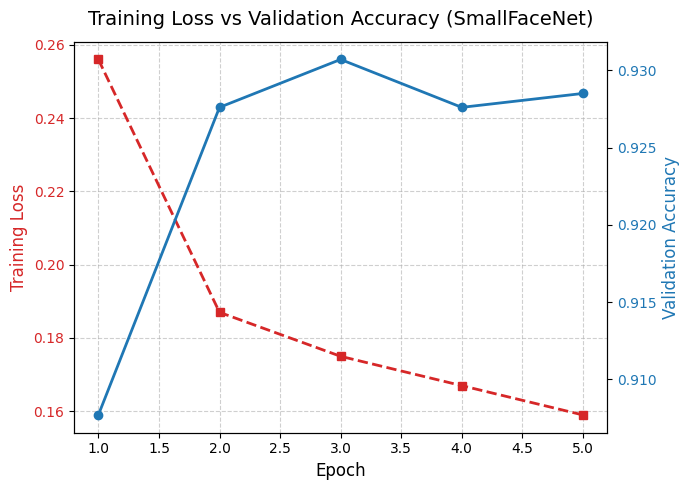

In [1]:

epochs = [1, 2, 3, 4, 5]

fig, ax1 = plt.subplots(figsize=(7,5))

# Plot training loss (left y-axis)
ax1.plot(epochs, train_losses, 's--', color='tab:red', linewidth=2, label='Training Loss')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Training Loss", color='tab:red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:red')

# Plot validation accuracy (right y-axis)
ax2 = ax1.twinx()
ax2.plot(epochs, val_accuracies, 'o-', color='tab:blue', linewidth=2, label='Validation Accuracy')
ax2.set_ylabel("Validation Accuracy", color='tab:blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title & grid
plt.title("Training Loss vs Validation Accuracy (SmallFaceNet)", fontsize=14, pad=12)
ax1.grid(True, linestyle='--', alpha=0.6)

fig.tight_layout()
plt.show()


In [ ]:
# BIM(Iterative P-FGSM) attack implementation on smallfaceNet
def bim_attack_batch(model, x, y, eps=8/255.0, alpha=2/255.0, iters=4, device='cuda'):
    """
    x: tensor [B,1,H,W] float32 [0,1]
    y: tensor [B] labels
    returns: x_adv [B,1,H,W] float32 [0,1]
    """
    x_adv = x.clone().detach().to(device)
    x_orig = x.clone().detach().to(device)
    for i in range(iters):
        x_adv.requires_grad_()
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y.to(device))
        model.zero_grad()
        loss.backward()
        grad = x_adv.grad.data
        x_adv = x_adv + alpha * torch.sign(grad)
        # projection
        diff = torch.clamp(x_adv - x_orig, min=-eps, max=eps)
        x_adv = torch.clamp(x_orig + diff, 0.0, 1.0).detach()
    return x_adv

# generate adversarial images for the test set
out_dir = Path("/kaggle/working/adv_test")
out_dir.mkdir(parents=True, exist_ok=True)

eps = 8/255.0
alpha = 2/255.0
iters = 4

# iterate test_loader and save adv images and corresponding original
for imgs, labels, fnames in tqdm(test_loader, desc="Generating BIM adv (test)"):
    imgs = imgs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        orig_logits = model(imgs)
        orig_preds = orig_logits.argmax(dim=1)
    imgs_adv = bim_attack_batch(model, imgs, labels, eps=eps, alpha=alpha, iters=iters, device=device)

    imgs_adv_cpu = imgs_adv.detach().cpu().numpy()
    imgs_cpu = imgs.detach().cpu().numpy()

    for adv_arr, orig_arr, fname in zip(imgs_adv_cpu, imgs_cpu, fnames):
        # each tensor: [1,H,W] in [0,1] float32
        adv_arr = np.squeeze(adv_arr)       # [H,W]
        orig_arr = np.squeeze(orig_arr)     # [H,W]

        # convert to uint8 explicitly
        adv_uint8 = np.clip(adv_arr * 255.0, 0, 255).astype(np.uint8)
        orig_uint8 = np.clip(orig_arr * 255.0, 0, 255).astype(np.uint8)

        # build paths
        adv_path = out_dir / f"adv_{fname}"
        orig_path = out_dir / f"orig_{fname}"

        # always save as PNG (safe for grayscale + float rounding)
        Image.fromarray(adv_uint8, mode='L').save(str(adv_path).replace(".jpg", ".png"))
        Image.fromarray(orig_uint8, mode='L').save(str(orig_path).replace(".jpg", ".png"))

print("Saved adversarial images to:", out_dir)

Generating BIM adv (test): 100%|██████████| 312/312 [01:52<00:00,  2.77it/s]

Saved adversarial images to: /kaggle/working/adv_test


In [14]:
mtcnn = MTCNN(keep_all=False, device=device if device != "cpu" else "cpu")

def flm_attack_batch(imgs, max_shift=6):
    """
    Simplified landmark-based geometric attack.
    Uses MTCNN to detect landmarks, adds small random perturbations,
    and applies PiecewiseAffine warp.
    imgs: torch.Tensor [B,1,H,W] in [0,1]
    """
    imgs_np = imgs.cpu().squeeze(1).numpy()  # [B,H,W]
    out = []
    for im in imgs_np:
        pil = Image.fromarray((im * 255).astype(np.uint8)).convert("RGB")
        boxes, probs, points = mtcnn.detect(pil, landmarks=True)
        if points is None or len(points) == 0:
            # fallback to small random affine
            tform = sktf.AffineTransform(translation=(np.random.uniform(-2,2), np.random.uniform(-2,2)))
            warped = sktf.warp(im, tform.inverse, output_shape=im.shape)
            out.append(warped.astype(np.float32))
            continue

        pts = points[0]  # (5,2)
        h, w = im.shape
        src = np.vstack([pts, [0,0], [w-1,0], [w-1,h-1], [0,h-1]])
        shifts = (np.random.randn(*src.shape) * (max_shift/4)).astype(np.float32)
        dst = np.clip(src + shifts, 0, [w-1, h-1]).astype(np.float32)
        tform = sktf.PiecewiseAffineTransform()
        try:
            tform.estimate(src, dst)
            warped = sktf.warp(im, tform, output_shape=im.shape)
        except Exception:
            warped = im
        out.append(warped.astype(np.float32))
    return np.stack(out)[:, None, :, :]  # [B,1,H,W]


# Generate FLM adversarial images

flm_out_dir = Path("/kaggle/working/adv_test_flm")
flm_out_dir.mkdir(parents=True, exist_ok=True)

for imgs, labels, fnames in tqdm(test_loader, desc="Generating FLM adv (test)"):
    imgs = imgs.to(device)
    imgs_adv_np = flm_attack_batch(imgs, max_shift=6)
    imgs_adv_uint8 = (imgs_adv_np.squeeze(1) * 255).astype(np.uint8)
    imgs_orig_uint8 = (imgs.cpu().squeeze(1).numpy() * 255).astype(np.uint8)

    # ---- Robust save loop for FLM outputs (force shape/dtype/mode) ----
    for adv_arr, orig_arr, fname in zip(imgs_adv_uint8, imgs_orig_uint8, fnames):
        # adv_arr / orig_arr may be (H,W), (H,W,1) or (1,H,W) etc. We sanitize.
    
        # 1) Squeeze any singleton dims
        adv_arr = np.squeeze(adv_arr)
        orig_arr = np.squeeze(orig_arr)
    
        # 2) If values are floats in [0,1], scale up; if already uint8, keep
        if not np.issubdtype(adv_arr.dtype, np.integer):
            # assume float in [0,1]
            adv_uint8 = np.clip(adv_arr * 255.0, 0, 255).astype(np.uint8)
        else:
            adv_uint8 = adv_arr.astype(np.uint8)
    
        if not np.issubdtype(orig_arr.dtype, np.integer):
            orig_uint8 = np.clip(orig_arr * 255.0, 0, 255).astype(np.uint8)
        else:
            orig_uint8 = orig_arr.astype(np.uint8)
    
        # 3) Ensure 2-D shape for grayscale. If it's 3-D with last dim 1 or first dim 1 -> squeeze again.
        if adv_uint8.ndim == 3 and adv_uint8.shape[-1] == 1:
            adv_uint8 = adv_uint8[:, :, 0]
        if adv_uint8.ndim == 3 and adv_uint8.shape[0] == 1:
            adv_uint8 = adv_uint8[0]
    
        if orig_uint8.ndim == 3 and orig_uint8.shape[-1] == 1:
            orig_uint8 = orig_uint8[:, :, 0]
        if orig_uint8.ndim == 3 and orig_uint8.shape[0] == 1:
            orig_uint8 = orig_uint8[0]
    
        # 4) Fallback: if still not 2-D (weird case), convert to grayscale by averaging channels
        if adv_uint8.ndim == 3:
            adv_uint8 = np.mean(adv_uint8, axis=2).astype(np.uint8)
        if orig_uint8.ndim == 3:
            orig_uint8 = np.mean(orig_uint8, axis=2).astype(np.uint8)
    
        # 5) Final safety: replace NaN/inf
        adv_uint8 = np.nan_to_num(adv_uint8, nan=0, posinf=255, neginf=0).astype(np.uint8)
        orig_uint8 = np.nan_to_num(orig_uint8, nan=0, posinf=255, neginf=0).astype(np.uint8)
    
        # 6) Save as PNG (safe for grayscale). If you must use JPEG, uncomment the conversion to RGB below.
        adv_path = flm_out_dir / f"adv_{fname}"
        orig_path = flm_out_dir / f"orig_{fname}"
        # use .png extension to avoid any jpeg mode issues
        adv_path = Path(str(adv_path).rsplit('.', 1)[0] + ".png")
        orig_path = Path(str(orig_path).rsplit('.', 1)[0] + ".png")
    
        Image.fromarray(adv_uint8, mode='L').save(str(adv_path))
        Image.fromarray(orig_uint8, mode='L').save(str(orig_path))
    
        # --- Optional: If you prefer JPEG and want to force 3 channels, use this instead:
        # adv_rgb = cv2.cvtColor(adv_uint8, cv2.COLOR_GRAY2BGR)
        # orig_rgb = cv2.cvtColor(orig_uint8, cv2.COLOR_GRAY2BGR)
        # Image.fromarray(adv_rgb, mode='RGB').save(str(adv_path.with_suffix('.jpg')))
        # Image.fromarray(orig_rgb, mode='RGB').save(str(orig_path.with_suffix('.jpg')))


print("Saved FLM adversarial images to:", flm_out_dir)


Generating FLM adv (test): 100%|██████████| 312/312 [06:50<00:00,  1.31s/it]

Saved FLM adversarial images to: /kaggle/working/adv_test_flm


In [20]:
def apply_bilateral_uint8(img_uint8, d=5, sigma_color=75, sigma_space=75):
    
    return cv2.bilateralFilter(img_uint8, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)

class ResidualBlock(nn.Module):
    def __init__(self, n_feats=64):
        super().__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, 3, padding=1)
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return x + out * 0.1  # small residual scaling

class SimpleEDSR(nn.Module):
    def __init__(self, n_resblocks=8, n_feats=64, in_ch=3, out_ch=3):
        super().__init__()
        self.head = nn.Conv2d(in_ch, n_feats, 3, padding=1)
        self.body = nn.Sequential(*[ResidualBlock(n_feats) for _ in range(n_resblocks)])
        self.tail = nn.Conv2d(n_feats, out_ch, 3, padding=1)
    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        out = self.tail(res)
        return out

def load_edsr_model(checkpoint_path: str = None, device='cpu'):
    if checkpoint_path is None:
        return None
    if not os.path.isfile(checkpoint_path):
        print(f"[EDSR] checkpoint not found at: {checkpoint_path}")
        return None
    model = SimpleEDSR(n_resblocks=8, n_feats=64, in_ch=3, out_ch=3).to(device)
    try:
        ckpt = torch.load(checkpoint_path, map_location=device)
        # Support dict with state_dict or raw state_dict
        if "state_dict" in ckpt:
            sd = ckpt["state_dict"]
        else:
            sd = ckpt
        # Try to load state dict robustly
        model.load_state_dict(sd, strict=False)
        model.eval()
        print("[EDSR] Loaded checkpoint:", checkpoint_path)
        return model
    except Exception as e:
        print("[EDSR] Failed to load checkpoint:", e)
        return None

def restore_image_uint8(img_uint8,
                        bilateral_params=(5, 75, 75),
                        edsr_model=None,
                        device='cpu'):
    
    # Bilateral filter (uint8)
    d, sigma_color, sigma_space = bilateral_params
    bl = apply_bilateral_uint8(img_uint8, d=d, sigma_color=sigma_color, sigma_space=sigma_space)  # HxW uint8

    # If no EDSR model, just return BL result as normalized float [0,1]
    if edsr_model is None:
        return bl.astype(np.float32) / 255.0

    # Run EDSR refinement (model expects 3-channel float tensor)
    img3 = np.stack([bl, bl, bl], axis=2)  # HxWx3 uint8
    # to tensor [B,3,H,W], float, normalized [0,1]
    t = torch.from_numpy(img3.transpose(2,0,1)).unsqueeze(0).float() / 255.0
    t = t.to(device)
    with torch.no_grad():
        out = edsr_model(t)  # [1,3,H,W] float
        out = torch.clamp(out, 0.0, 1.0)
    out_np = (out.squeeze(0).cpu().numpy().transpose(1,2,0) * 255.0).astype(np.uint8)  # HxWx3
    # Convert back to grayscale (same weighted sum)
    gray = (0.299 * out_np[:,:,0] + 0.587 * out_np[:,:,1] + 0.114 * out_np[:,:,2]).astype(np.float32) / 255.0
    return gray  # HxW float32 in [0,1]

# read adv images, restore, save
def batch_restore_adv_folder(adv_folder: str,
                             out_folder: str,
                             bilateral_params=(5,75,75),
                             edsr_checkpoint: str = None,
                             device='cuda'):
    adv_folder = Path(adv_folder)
    out_folder = Path(out_folder)
    out_folder.mkdir(parents=True, exist_ok=True)

    # load model if checkpoint provided
    edsr_model = None
    if edsr_checkpoint:
        edsr_model = load_edsr_model(edsr_checkpoint, device=device)
        if edsr_model is not None:
            edsr_model.eval()
    else:
        print("[EDSR] No checkpoint provided; skipping EDSR refinement (only bilateral filter applied).")

    # look for PNG and JPG
    adv_paths = sorted([p for ext in ("png", "jpg", "jpeg") for p in adv_folder.glob(f"adv_*.{ext}")])
    print(f"Found {len(adv_paths)} adversarial images. Restoring to: {out_folder}")

    for adv_path in tqdm(adv_paths, desc="Restoring images"):
        try:
            name = adv_path.name.replace("adv_", "").rsplit(".", 1)[0]
            img = Image.open(adv_path).convert("L")  # grayscale
            arr = np.array(img)
            if arr.shape != (128,128):
                arr = cv2.resize(arr, (128,128), interpolation=cv2.INTER_LINEAR)
            restored = restore_image_uint8(arr, bilateral_params=bilateral_params, edsr_model=edsr_model, device=device)
            # restored is float32 HxW in [0,1]
            save_path = out_folder / f"restored_{name}.png"
            Image.fromarray((restored * 255.0).astype(np.uint8)).save(str(save_path))
        except Exception as e:
            print(f"Failed for {adv_path}: {e}")

    print("Restore pass complete.")


ADV_DIR = "/kaggle/working/adv_test"
OUT_DIR = "/kaggle/working/restored_test"
EDSR_CKPT = None

# paper suggests tuning sigma_s and sigma_r
bilateral_params = (5, 75, 75)  # (d, sigmaColor, sigmaSpace)

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_restore_adv_folder(ADV_DIR, OUT_DIR, bilateral_params=bilateral_params, edsr_checkpoint=EDSR_CKPT, device=device)

[EDSR] No checkpoint provided; skipping EDSR refinement (only bilateral filter applied).
Found 19962 adversarial images. Restoring to: /kaggle/working/restored_test


Restoring images: 100%|██████████| 19962/19962 [00:50<00:00, 393.29it/s]

Restore pass complete.


In [18]:
from pathlib import Path
p = Path("/kaggle/working/adv_test")
print("Exists:", p.exists())
print("Files:", sorted([str(x.name) for x in p.iterdir()])[:50])
# Also check the FLM folder if you used that
p2 = Path("/kaggle/working/adv_test_flm")
print("adv_test_flm Exists:", p2.exists())
print("Files:", sorted([str(x.name) for x in p2.iterdir()])[:50])


Exists: True
Files: ['adv_182638.png', 'adv_182639.png', 'adv_182640.png', 'adv_182641.png', 'adv_182642.png', 'adv_182643.png', 'adv_182644.png', 'adv_182645.png', 'adv_182646.png', 'adv_182647.png', 'adv_182648.png', 'adv_182649.png', 'adv_182650.png', 'adv_182651.png', 'adv_182652.png', 'adv_182653.png', 'adv_182654.png', 'adv_182655.png', 'adv_182656.png', 'adv_182657.png', 'adv_182658.png', 'adv_182659.png', 'adv_182660.png', 'adv_182661.png', 'adv_182662.png', 'adv_182663.png', 'adv_182664.png', 'adv_182665.png', 'adv_182666.png', 'adv_182667.png', 'adv_182668.png', 'adv_182669.png', 'adv_182670.png', 'adv_182671.png', 'adv_182672.png', 'adv_182673.png', 'adv_182674.png', 'adv_182675.png', 'adv_182676.png', 'adv_182677.png', 'adv_182678.png', 'adv_182679.png', 'adv_182680.png', 'adv_182681.png', 'adv_182682.png', 'adv_182683.png', 'adv_182684.png', 'adv_182685.png', 'adv_182686.png', 'adv_182687.png']
adv_test_flm Exists: True
Files: ['adv_182638.png', 'adv_182639.png', 'adv_1826

In [21]:
def wlmp_features(img_uint8): # returns feature vector 1d np array
    H, W = img_uint8.shape
    # pad 1 pixel around so we can form 3x3 blocks
    padded = np.pad(img_uint8, 1, mode='reflect')
    
    # extract 3x3 blocks using sliding window
    blocks = view_as_windows(padded, (3,3))  # shape (H,W,3,3)
    H_b, W_b, _, _ = blocks.shape
    
    # center pixels
    centers = blocks[:,:,1,1]
    
    # neighbors (8 around center)
    neighbors = np.concatenate([
        blocks[:,:,0,0].reshape(H_b,W_b,1), blocks[:,:,0,1].reshape(H_b,W_b,1), blocks[:,:,0,2].reshape(H_b,W_b,1),
        blocks[:,:,1,0].reshape(H_b,W_b,1),                           blocks[:,:,1,2].reshape(H_b,W_b,1),
        blocks[:,:,2,0].reshape(H_b,W_b,1), blocks[:,:,2,1].reshape(H_b,W_b,1), blocks[:,:,2,2].reshape(H_b,W_b,1)
    ], axis=2)  # shape (H_b, W_b, 8)
    
    # abs differences
    diffs = np.abs(neighbors - centers[:,:,None])  # (H,W,8)
    
    # sort ascending
    diffs_sorted = np.sort(diffs, axis=2)
    
    # apply weights 2^p
    weights = (2 ** np.arange(8)).astype(np.int32)  # [1,2,4,...,128]
    weighted = (diffs_sorted * weights).sum(axis=2)
    
    # clip to 0-255
    coded = np.clip(weighted, 0, 255).astype(np.uint8)
    
    # histogram feature vector (256 bins)
    hist, _ = np.histogram(coded, bins=256, range=(0,256), density=True)
    
    return hist.astype(np.float32)

In [24]:
# load one restored or adv image
img = Image.open("/kaggle/working/restored_test/restored_182638.png").convert("L")
arr = np.array(img)

# extract WLMP histogram
feat = wlmp_features(arr)
print("WLMP feature shape:", feat.shape)  # (256,)


WLMP feature shape: (256,)


In [27]:
def build_wlmp_dataset(orig_dir, adv_dir, max_samples=None):
    X, y = [], []
    orig_dir, adv_dir = Path(orig_dir), Path(adv_dir)

    # find both png and jpg
    orig_paths = sorted([p for ext in ("png", "jpg", "jpeg") for p in orig_dir.glob(f"orig_*.{ext}")])
    adv_paths  = sorted([p for ext in ("png", "jpg", "jpeg") for p in adv_dir.glob(f"adv_*.{ext}")])

    if max_samples:
        orig_paths = orig_paths[:max_samples]
        adv_paths  = adv_paths[:max_samples]

    if len(orig_paths) == 0 or len(adv_paths) == 0:
        print(f"[WARN] No original or adversarial images found in {orig_dir} or {adv_dir}")
        print(f"orig_paths={len(orig_paths)}, adv_paths={len(adv_paths)}")
        return np.empty((0,256)), np.empty((0,))

    # originals = label 0
    for p in tqdm(orig_paths, desc="Extracting ORIG features"):
        img = np.array(Image.open(p).convert("L"))
        X.append(wlmp_features(img))
        y.append(0)

    # adversarial = label 1
    for p in tqdm(adv_paths, desc="Extracting ADV features"):
        img = np.array(Image.open(p).convert("L"))
        X.append(wlmp_features(img))
        y.append(1)

    X = np.stack(X)
    y = np.array(y)
    return X, y


In [28]:
ORIG_DIR = "/kaggle/working/adv_test"     # contains orig_*.jpg
ADV_DIR  = "/kaggle/working/adv_test"     # contains adv_*.jpg

# build dataset
X, y = build_wlmp_dataset(ORIG_DIR, ADV_DIR, max_samples=2000) 

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# train SVM (RBF kernel for starting)
svm_clf = SVC(kernel='rbf', gamma='scale')
svm_clf.fit(X_train, y_train)

# evaluate
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Extracting ADV features: 100%|██████████| 2000/2000 [00:06<00:00, 297.57it/s]


              precision    recall  f1-score   support

           0       1.00      0.68      0.81       600
           1       0.75      1.00      0.86       600

    accuracy                           0.84      1200
   macro avg       0.88      0.84      0.83      1200
weighted avg       0.88      0.84      0.83      1200

[[405 195]
 [  0 600]]


In [30]:
# Compare WLMP classification before vs after restoration
RESTORED_DIR = "/kaggle/working/restored_test"

def build_wlmp_pairs(orig_folder, adv_folder, restored_folder, max_samples=1000):
    orig_folder, adv_folder, restored_folder = Path(orig_folder), Path(adv_folder), Path(restored_folder)

    # find both PNG and JPG
    orig_paths = sorted([p for ext in ("png","jpg","jpeg") for p in orig_folder.glob(f"orig_*.{ext}")])[:max_samples]
    adv_paths  = sorted([p for ext in ("png","jpg","jpeg") for p in adv_folder.glob(f"adv_*.{ext}")])[:max_samples]
    rest_paths = sorted([p for ext in ("png","jpg","jpeg") for p in restored_folder.glob(f"restored_*.{ext}")])[:max_samples]

    print(f"Found {len(orig_paths)} orig, {len(adv_paths)} adv, {len(rest_paths)} restored")

    if len(orig_paths) == 0 or len(adv_paths) == 0 or len(rest_paths) == 0:
        print("[WARN] One or more folders are empty — check paths or extensions.")
        return np.empty((0,256)), np.empty((0,)), np.empty((0,256)), np.empty((0,))

    X_clean, y_clean = [], []
    for p in tqdm(orig_paths, desc="WLMP Clean"):
        arr = np.array(Image.open(p).convert("L"))
        X_clean.append(wlmp_features(arr))
        y_clean.append(0)

    X_adv, y_adv = [], []
    for p in tqdm(adv_paths, desc="WLMP Adv"):
        arr = np.array(Image.open(p).convert("L"))
        X_adv.append(wlmp_features(arr))
        y_adv.append(1)

    X_rest, y_rest = [], []
    for p in tqdm(rest_paths, desc="WLMP Restored"):
        arr = np.array(Image.open(p).convert("L"))
        X_rest.append(wlmp_features(arr))
        y_rest.append(1)

    X_before = np.vstack([X_clean, X_adv])
    y_before = np.hstack([y_clean, y_adv])
    X_after = np.vstack([X_clean, X_rest])
    y_after = np.hstack([y_clean, y_rest])

    return X_before, y_before, X_after, y_after



X_before, y_before, X_after, y_after = build_wlmp_pairs(
    orig_folder="/kaggle/working/adv_test",
    adv_folder="/kaggle/working/adv_test",
    restored_folder=RESTORED_DIR,
    max_samples=1000
)

Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(X_before, y_before, test_size=0.3, stratify=y_before)
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(X_after, y_after, test_size=0.3, stratify=y_after)

classifiers = {
    "LinearSVM": SVC(kernel='linear'),
    "RBF-SVM": SVC(kernel='rbf', gamma='scale'),
    "RandomForest": RandomForestClassifier(n_estimators=150, random_state=42),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}
print("\n=== WLMP Classification Results ===")
for name, clf in classifiers.items():
    clf.fit(Xb_tr, yb_tr)
    acc_before = clf.score(Xb_te, yb_te)
    clf.fit(Xa_tr, ya_tr)
    acc_after = clf.score(Xa_te, ya_te)
    results[name] = (acc_before, acc_after)
    print(f"{name:<15} | Before: {acc_before*100:.2f}% | After: {acc_after*100:.2f}%")

# optional: save results summary
pd.DataFrame(results, index=["Before", "After"]).T.to_csv("/kaggle/working/wlmp_results.csv")

Found 1000 orig, 1000 adv, 1000 restored


WLMP Restored: 100%|██████████| 1000/1000 [00:03<00:00, 317.16it/s]



=== WLMP Classification Results ===
LinearSVM       | Before: 77.50% | After: 69.67%
RBF-SVM         | Before: 81.33% | After: 72.67%
RandomForest    | Before: 97.17% | After: 96.50%
kNN             | Before: 97.33% | After: 96.83%


Found 19962 adversarial files.


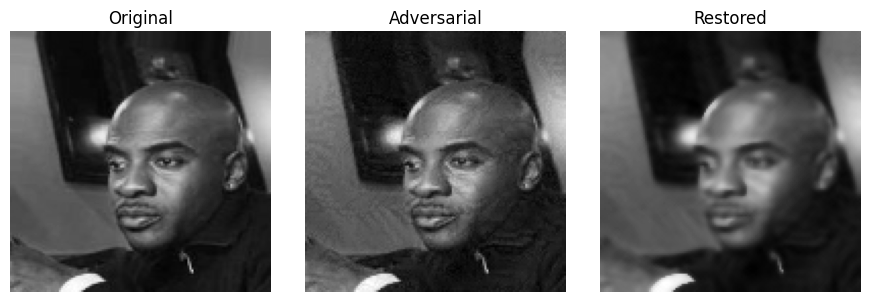

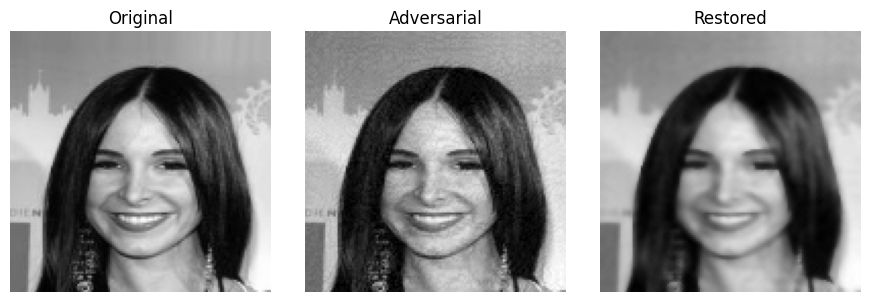

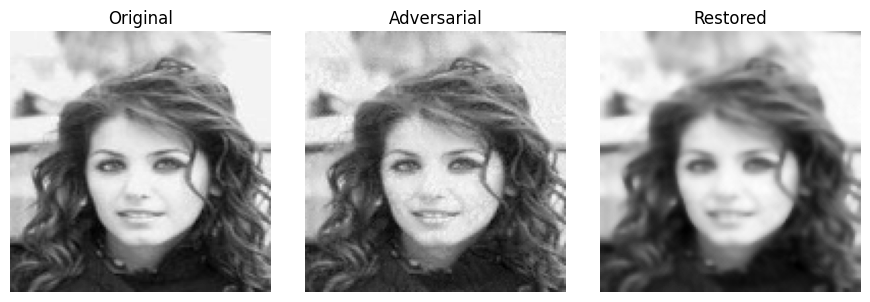

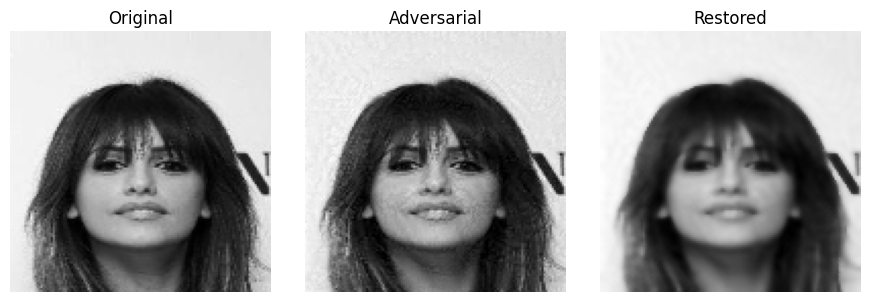

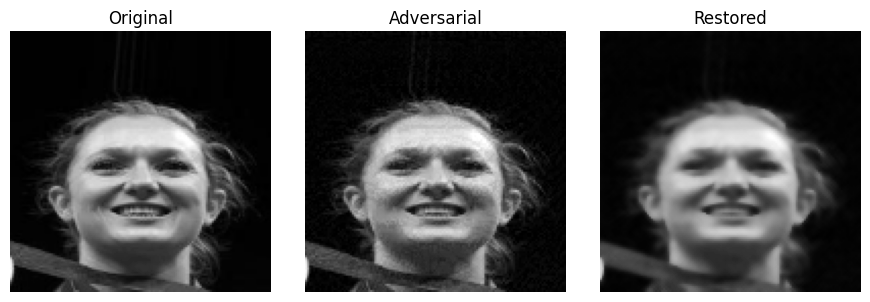

In [ ]:
# Use PNGs instead of JPGs
adv_files = sorted([p for ext in ("png", "jpg", "jpeg") for p in Path(ADV_DIR).glob(f"adv_*.{ext}")])
print(f"Found {len(adv_files)} adversarial files.")

# Handle edge case where fewer than 5 exist
n_show = min(5, len(adv_files))
if n_show == 0:
    print("[WARN] No adversarial files found in", ADV_DIR)
else:
    triplets = random.sample(adv_files, n_show)
    for t in triplets:
        name = t.name.replace("adv_", "")
        # find corresponding orig/restored (with same extension)
        orig_path = next((p for p in Path(ADV_DIR).glob(f"orig_{name.rsplit('.',1)[0]}.*")), None)
        rest_path = next((p for p in Path(OUT_DIR).glob(f"restored_{name.rsplit('.',1)[0]}.*")), None)
        
        if not orig_path or not rest_path:
            print(f"[WARN] Missing orig/restored for {name}, skipping")
            continue
        
        orig = np.array(Image.open(orig_path).convert("L"))
        adv = np.array(Image.open(t).convert("L"))
        rest = np.array(Image.open(rest_path).convert("L"))
        
        fig, axs = plt.subplots(1, 3, figsize=(9, 3))
        for ax, im, title in zip(axs, [orig, adv, rest], ["Original", "Adversarial", "Restored"]):
            ax.imshow(im, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        plt.tight_layout()
        plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

# optional seaborn for nicer heatmaps (fallback to matplotlib)
try:
    import seaborn as sns
    sns.set(style="whitegrid")
    HAS_SNS = True
except Exception:
    HAS_SNS = False


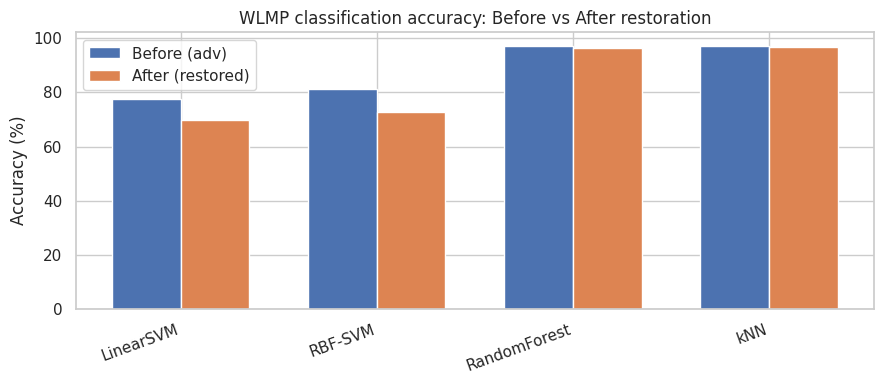

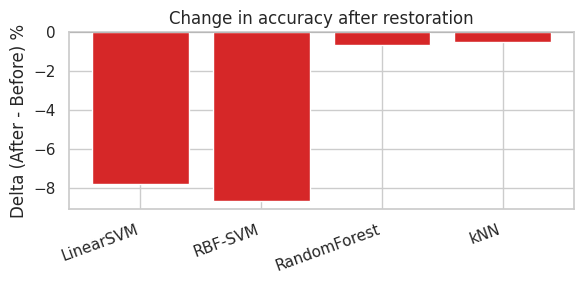

In [34]:
# requires `results` dict: {name: (acc_before, acc_after), ...}
if 'results' not in globals() or len(results)==0:
    print("No `results` dict found. Run the WLMP comparison block first.")
else:
    names = list(results.keys())
    before = [results[n][0] for n in names]
    after  = [results[n][1] for n in names]

    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(x - width/2, np.array(before)*100, width, label='Before (adv)')
    ax.bar(x + width/2, np.array(after)*100, width, label='After (restored)')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('WLMP classification accuracy: Before vs After restoration')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=20, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # also show delta
    delta = (np.array(after)-np.array(before))*100
    fig, ax = plt.subplots(figsize=(6,3))
    colors = ['tab:green' if d>0 else 'tab:red' for d in delta]
    ax.bar(names, delta, color=colors)
    ax.axhline(0, color='k', linewidth=0.6)
    ax.set_ylabel('Delta (After - Before) %')
    ax.set_title('Change in accuracy after restoration')
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()


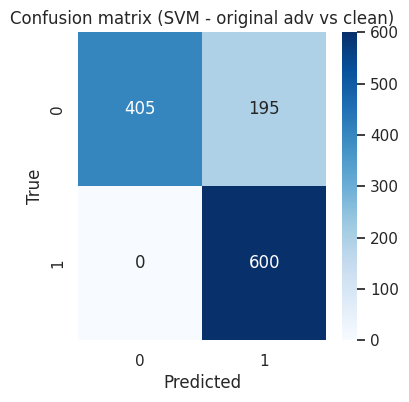

In [35]:
# uses y_test and y_pred from earlier SVM evaluation
if ('y_test' in globals()) and ('y_pred' in globals()):
    cm = confusion_matrix(y_test, y_pred)
    if HAS_SNS:
        fig, ax = plt.subplots(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title('Confusion matrix (SVM - original adv vs clean)')
        plt.show()
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(cmap='Blues')
        plt.title('Confusion matrix (SVM)')
        plt.show()
else:
    print("Skipping confusion matrix — `y_test` and/or `y_pred` not present.")


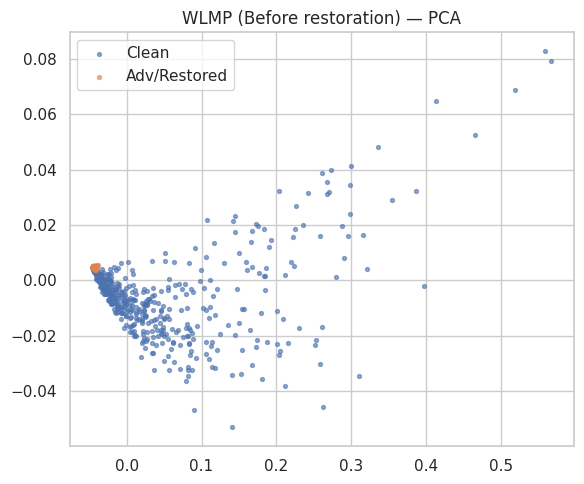

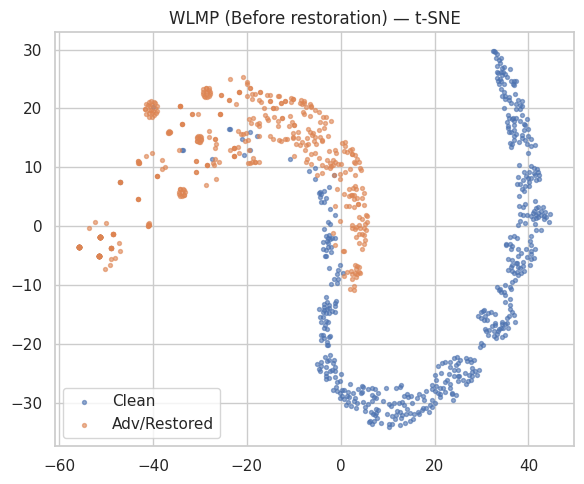

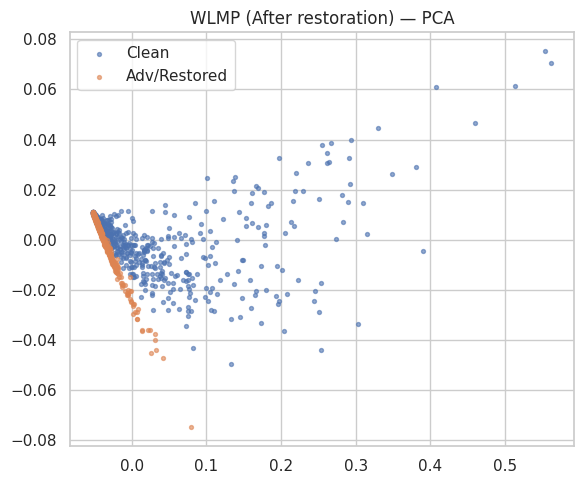

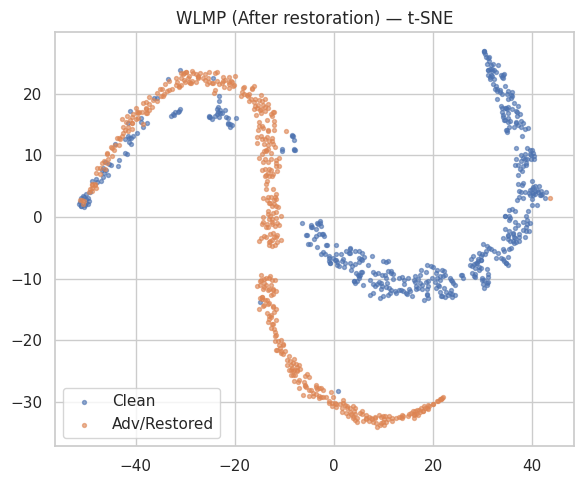

In [36]:
# Visualize WLMP clusters before and after restoration
def plot_emb(X, y, title="embedding (2D)", method='pca', n_samples=1000, random_state=42):
    if X.shape[0] == 0:
        print("Empty X, skipping embedding.")
        return
    n = min(n_samples, X.shape[0])
    idx = np.random.RandomState(random_state).choice(X.shape[0], size=n, replace=False)
    Xs = X[idx]
    ys = y[idx]

    if method == 'pca':
        emb = PCA(n_components=2, random_state=random_state).fit_transform(Xs)
    else:
        emb = TSNE(n_components=2, init='pca', random_state=random_state, perplexity=30).fit_transform(Xs)

    plt.figure(figsize=(6,5))
    plt.scatter(emb[ys==0,0], emb[ys==0,1], s=8, label='Clean', alpha=0.6)
    plt.scatter(emb[ys==1,0], emb[ys==1,1], s=8, label='Adv/Restored', alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

if ('X_before' in globals()) and ('y_before' in globals()):
    plot_emb(X_before, y_before, title="WLMP (Before restoration) — PCA", method='pca')
    plot_emb(X_before, y_before, title="WLMP (Before restoration) — t-SNE", method='tsne', n_samples=1000)
if ('X_after' in globals()) and ('y_after' in globals()):
    plot_emb(X_after, y_after, title="WLMP (After restoration) — PCA", method='pca')
    plot_emb(X_after, y_after, title="WLMP (After restoration) — t-SNE", method='tsne', n_samples=1000)


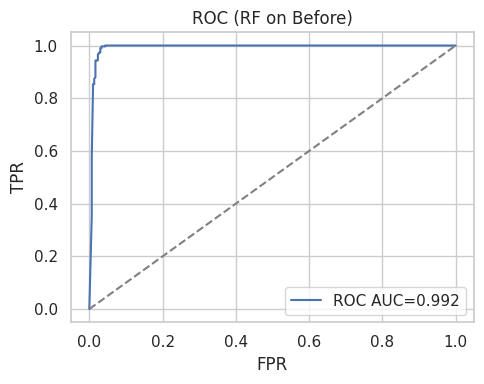

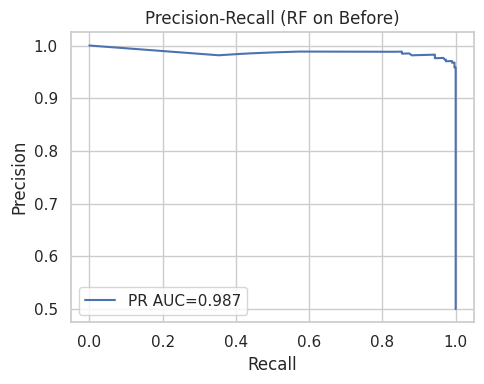

In [37]:
# Train RF on the before dataset and compute ROC/PR curves as an example
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

if ('X_before' in globals()) and (X_before.shape[0] > 0):
    Xtr, Xte, ytr, yte = train_test_split(X_before, y_before, test_size=0.3, stratify=y_before, random_state=42)
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(Xtr, ytr)
    if hasattr(rf, "predict_proba"):
        prob = rf.predict_proba(Xte)[:,1]
        fpr, tpr, _ = roc_curve(yte, prob)
        roc_auc = roc_auc_score(yte, prob)
        prec, rec, _ = precision_recall_curve(yte, prob)
        pr_auc = auc(rec, prec)

        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (RF on Before)'); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f'PR AUC={pr_auc:.3f}')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall (RF on Before)'); plt.legend(); plt.tight_layout(); plt.show()
    else:
        print("Classifier has no predict_proba — skipping ROC/PR.")
else:
    print("No X_before available for ROC/PR.")


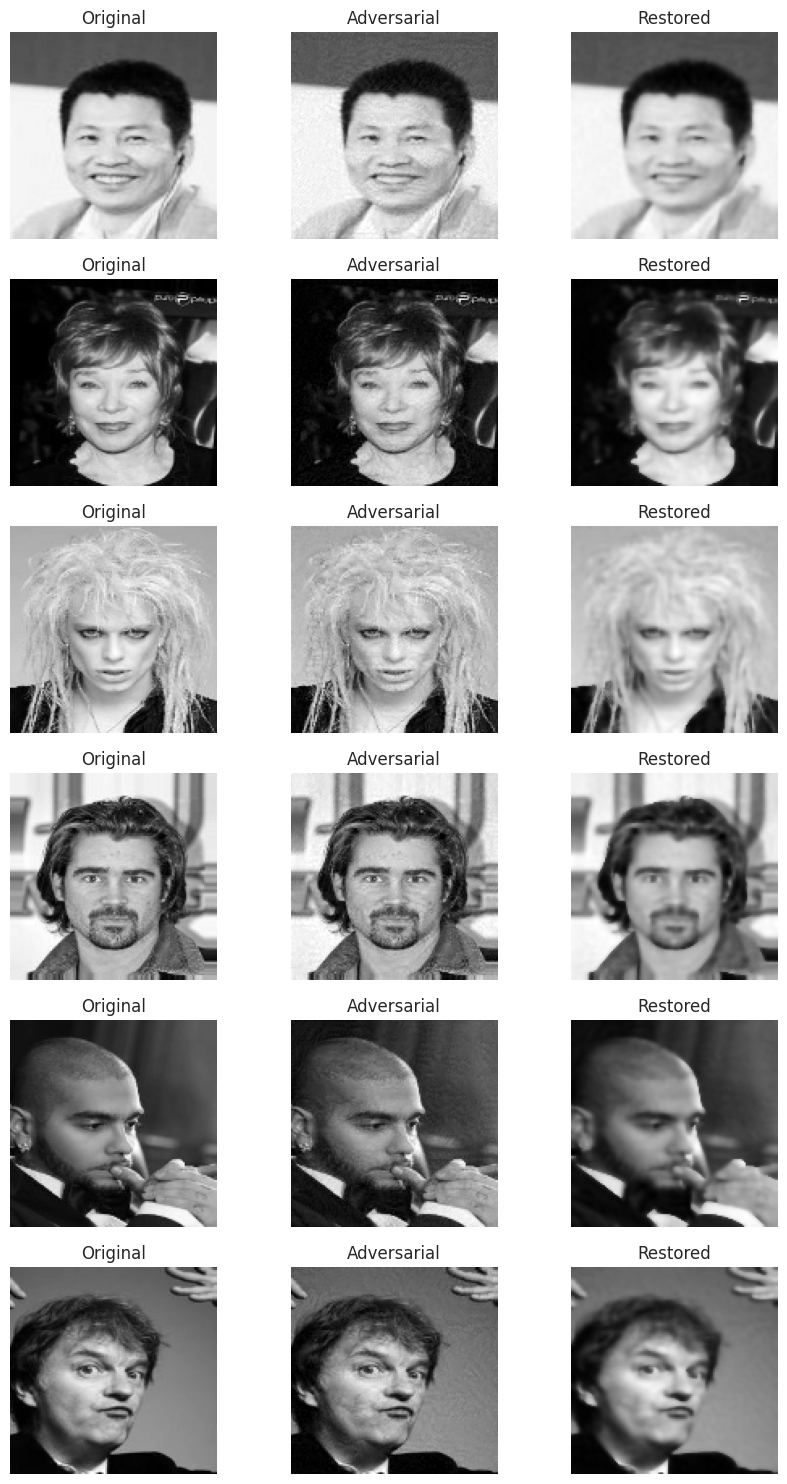

In [38]:
def show_triplets(folder_adv, folder_restored, n=8):
    adv_files = sorted([p for ext in ("png","jpg","jpeg") for p in Path(folder_adv).glob(f"adv_*.{ext}")])
    if len(adv_files) == 0:
        print("No adversarial files found in", folder_adv); return
    n = min(n, len(adv_files))
    picks = random.sample(adv_files, n)
    cols = 3
    rows = n
    plt.figure(figsize=(cols*3, rows*2.5))
    for i, adv in enumerate(picks):
        name = adv.name.replace("adv_", "").rsplit('.',1)[0]
        orig_path = next(iter(Path(folder_adv).glob(f"orig_{name}.*")), None)
        rest_path = next(iter(Path(folder_restored).glob(f"restored_{name}.*")), None)
        orig = np.array(Image.open(orig_path).convert("L")) if orig_path else np.zeros((128,128),np.uint8)
        adv_i = np.array(Image.open(adv).convert("L"))
        rest = np.array(Image.open(rest_path).convert("L")) if rest_path else np.zeros_like(adv_i)
        plt.subplot(n,3,i*3+1); plt.imshow(orig, cmap='gray'); plt.title("Original"); plt.axis('off')
        plt.subplot(n,3,i*3+2); plt.imshow(adv_i, cmap='gray'); plt.title("Adversarial"); plt.axis('off')
        plt.subplot(n,3,i*3+3); plt.imshow(rest, cmap='gray'); plt.title("Restored"); plt.axis('off')
    plt.tight_layout()
    plt.show()

# call it
show_triplets(ADV_DIR, OUT_DIR, n=6)
